In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as st
from arch import arch_model
from scipy.optimize import minimize
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf

### The data file money dem.csv contains quarterly observations for the following variables from 1959Q1 to 2001Q1:

#### - RGDP: real US GDP 

#### - GDP: nominal GDP 
    
#### - M2: Money supply

#### - Tb3mo: Three-month rate on US Treasury Bills


#### Real GDP Growth: $dlrgdp_{t}=\ln(RGDP_{t}/RGDP_{t-1})$

#### GDP Deflator: $price_{t}=GDP_{t}/RGDP_{t}$

#### Real Money supply growth: $dlrm2_{t}=\ln(M2_{t}/price_{t})-\ln(M2_{t-1}/price_{t-1})$

#### Changes in the short-term interest rate $drs_{t}=tb3mo_{t}-tb3mo_{t-1}$


In [2]:
data = pd.read_csv('money_dem.csv')
data

,DATE,GDP,RGDP,M2,TB3mo,Unnamed: 5
0,1959.1,496.1,2273.0,287.80,2.77,NaN
1,1959.2,509.2,2332.4,292.12,3.00,NaN
2,1959.3,510.2,2331.4,296.12,3.54,NaN
3,1959.4,514.2,2339.1,297.14,4.23,NaN
4,1960.1,527.9,2391.0,298.66,3.87,NaN
...,...,...,...,...,...,...
164,2000.1,9752.7,9191.8,4691.48,5.52,NaN
165,2000.2,9945.7,9318.9,4766.55,5.71,NaN
166,2000.3,10039.4,9369.5,4834.00,6.02,NaN
167,2000.4,10114.4,9393.7,4911.52,6.02,NaN


In [3]:
data['DATE'] = data['DATE'].apply(lambda x: f"{int(x)}Q{int(str(x).split('.')[1])}")
data['DATE'] = pd.to_datetime(data['DATE'])
#data = data.set_index('DATE')
data

,DATE,GDP,RGDP,M2,TB3mo,Unnamed: 5
0,1959-01-01,496.1,2273.0,287.80,2.77,NaN
1,1959-04-01,509.2,2332.4,292.12,3.00,NaN
2,1959-07-01,510.2,2331.4,296.12,3.54,NaN
3,1959-10-01,514.2,2339.1,297.14,4.23,NaN
4,1960-01-01,527.9,2391.0,298.66,3.87,NaN
...,...,...,...,...,...,...
164,2000-01-01,9752.7,9191.8,4691.48,5.52,NaN
165,2000-04-01,9945.7,9318.9,4766.55,5.71,NaN
166,2000-07-01,10039.4,9369.5,4834.00,6.02,NaN
167,2000-10-01,10114.4,9393.7,4911.52,6.02,NaN


In [4]:
data = data.drop(data.columns[-1], axis = 1)
data

,DATE,GDP,RGDP,M2,TB3mo
0,1959-01-01,496.1,2273.0,287.80,2.77
1,1959-04-01,509.2,2332.4,292.12,3.00
2,1959-07-01,510.2,2331.4,296.12,3.54
3,1959-10-01,514.2,2339.1,297.14,4.23
4,1960-01-01,527.9,2391.0,298.66,3.87
...,...,...,...,...,...
164,2000-01-01,9752.7,9191.8,4691.48,5.52
165,2000-04-01,9945.7,9318.9,4766.55,5.71
166,2000-07-01,10039.4,9369.5,4834.00,6.02
167,2000-10-01,10114.4,9393.7,4911.52,6.02


In [5]:
#%% Generate Variables
data['dlrgdp'] = np.log(data.RGDP).diff()
data['price']  = data.GDP/data.RGDP
data['dlrm2']  = np.log(data.M2/data.price).diff()
data['drs']    = data.TB3mo.diff()
data

,DATE,GDP,RGDP,M2,TB3mo,dlrgdp,price,dlrm2,drs
0,1959-01-01,496.1,2273.0,287.80,2.77,NaN,0.218258,NaN,NaN
1,1959-04-01,509.2,2332.4,292.12,3.00,0.025797,0.218316,0.014633,0.23
2,1959-07-01,510.2,2331.4,296.12,3.54,-0.000429,0.218838,0.011209,0.54
3,1959-10-01,514.2,2339.1,297.14,4.23,0.003297,0.219828,-0.001074,0.69
4,1960-01-01,527.9,2391.0,298.66,3.87,0.021945,0.220786,0.000753,-0.36
...,...,...,...,...,...,...,...,...,...
164,2000-01-01,9752.7,9191.8,4691.48,5.52,0.011786,1.061022,0.006317,0.48
165,2000-04-01,9945.7,9318.9,4766.55,5.71,0.013733,1.067261,0.010011,0.19
166,2000-07-01,10039.4,9369.5,4834.00,6.02,0.005415,1.071498,0.010090,0.31
167,2000-10-01,10114.4,9393.7,4911.52,6.02,0.002580,1.076722,0.011046,0.00


### a) Use the AIC, BIC and LR test to select the lag length of the VAR up to a maximum of 16 lags.

In [6]:
model = VAR(data[['dlrgdp','dlrm2','drs']].dropna())
results_aic_bic = []
for p in range(1, 17):  # loops from 1 to 16 lags
    result = model.fit(p)
    results_aic_bic.append((p, result.aic, result.bic))
    
    
# Convert the results to a DataFrame for easier handling
results_df = pd.DataFrame(results_aic_bic, columns=['Lag', 'AIC', 'BIC'])

print(results_df)

# Find the minimum AIC and BIC values
min_aic = results_df.AIC.min()
min_bic = results_df.BIC.min()

# Find the corresponding lag order for minimum AIC and BIC
lag_min_aic = results_df.Lag[results_df.AIC.idxmin()]
lag_min_bic = results_df.Lag[results_df.BIC.idxmin()]

# Print the results
print(f'Minimum AIC: {min_aic} at lag {lag_min_aic}')
print(f'Minimum BIC: {min_bic} at lag {lag_min_bic}')

    Lag        AIC        BIC
0     1 -20.359024 -20.134977
1     2 -20.466322 -20.072637
2     3 -20.455569 -19.890852
3     4 -20.462361 -19.725197
4     5 -20.574556 -19.663513
5     6 -20.493465 -19.407089
6     7 -20.480379 -19.217195
7     8 -20.560312 -19.118825
8     9 -20.578103 -18.956795
9    10 -20.553422 -18.750755
10   11 -20.560368 -18.574782
11   12 -20.502188 -18.332099
12   13 -20.451351 -18.095151
13   14 -20.339667 -17.795726
14   15 -20.328957 -17.595621
15   16 -20.267599 -17.343188
Minimum AIC: -20.578102693451775 at lag 9
Minimum BIC: -20.13497663320013 at lag 1


C:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### b) Fit VAR(4) and VAR(8) models to the data and compute the residual autocorrelations

In [7]:
data_clean = data[['dlrgdp','dlrm2','drs']].dropna()
data_clean

,dlrgdp,dlrm2,drs
1,0.025797,0.014633,0.23
2,-0.000429,0.011209,0.54
3,0.003297,-0.001074,0.69
4,0.021945,0.000753,-0.36
5,-0.004947,0.004739,-0.88
...,...,...,...
164,0.011786,0.006317,0.48
165,0.013733,0.010011,0.19
166,0.005415,0.010090,0.31
167,0.002580,0.011046,0.00


C:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


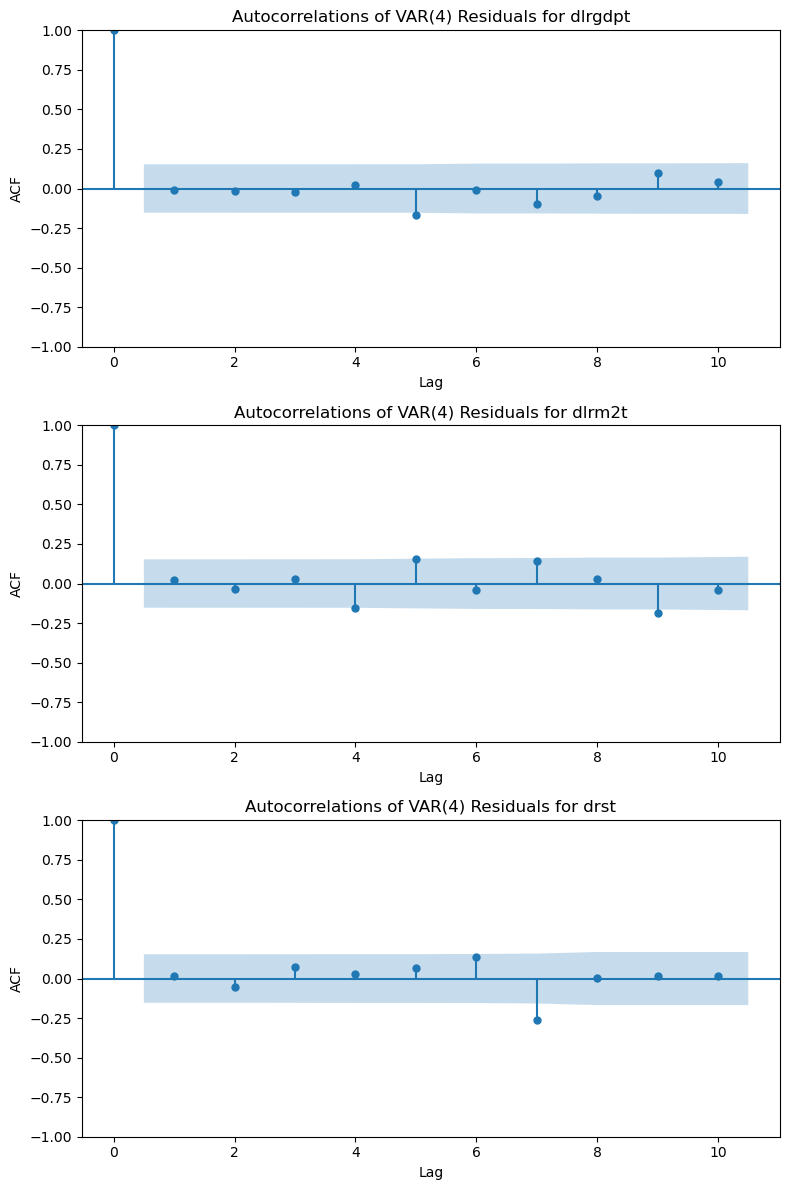

In [8]:
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf
# VAR(4) model
model_4 = VAR(data_clean).fit(4)

residuals_var4 = model_4.resid

acf_resid_var4_dlrgdp = acf(residuals_var4['dlrgdp'], nlags=10, fft=False)
acf_resid_var4_dlrm2 = acf(residuals_var4['dlrm2'], nlags=10, fft=False)
acf_resid_var4_drs = acf(residuals_var4['drs'], nlags=10, fft=False)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))


# dlrgdp
plot_acf(residuals_var4['dlrgdp'], ax=axes[0], lags=10, title='Autocorrelations of VAR(4) Residuals for dlrgdpt')
axes[0].set_ylabel('ACF')
axes[0].set_xlabel('Lag')

# dlrm2
plot_acf(residuals_var4['dlrm2'], ax=axes[1], lags=10, title='Autocorrelations of VAR(4) Residuals for dlrm2t')
axes[1].set_ylabel('ACF')
axes[1].set_xlabel('Lag')

# drs
plot_acf(residuals_var4['drs'], ax=axes[2], lags=10, title='Autocorrelations of VAR(4) Residuals for drst')
axes[2].set_ylabel('ACF')
axes[2].set_xlabel('Lag')

plt.tight_layout()
plt.show()



In [11]:
print(model_4.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Oct, 2023
Time:                     22:48:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -19.7252
Nobs:                     164.000    HQIC:                  -20.1631
Log likelihood:           1018.80    FPE:                1.29940e-09
AIC:                     -20.4624    Det(Omega_mle):     1.03361e-09
--------------------------------------------------------------------
Results for equation dlrgdp
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.004098         0.001158            3.540           0.000
L1.dlrgdp         0.108815         0.082987            1.311           0.190
L1.dlrm2          0.173071         0.103065            1.679           0.09

C:\Software\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


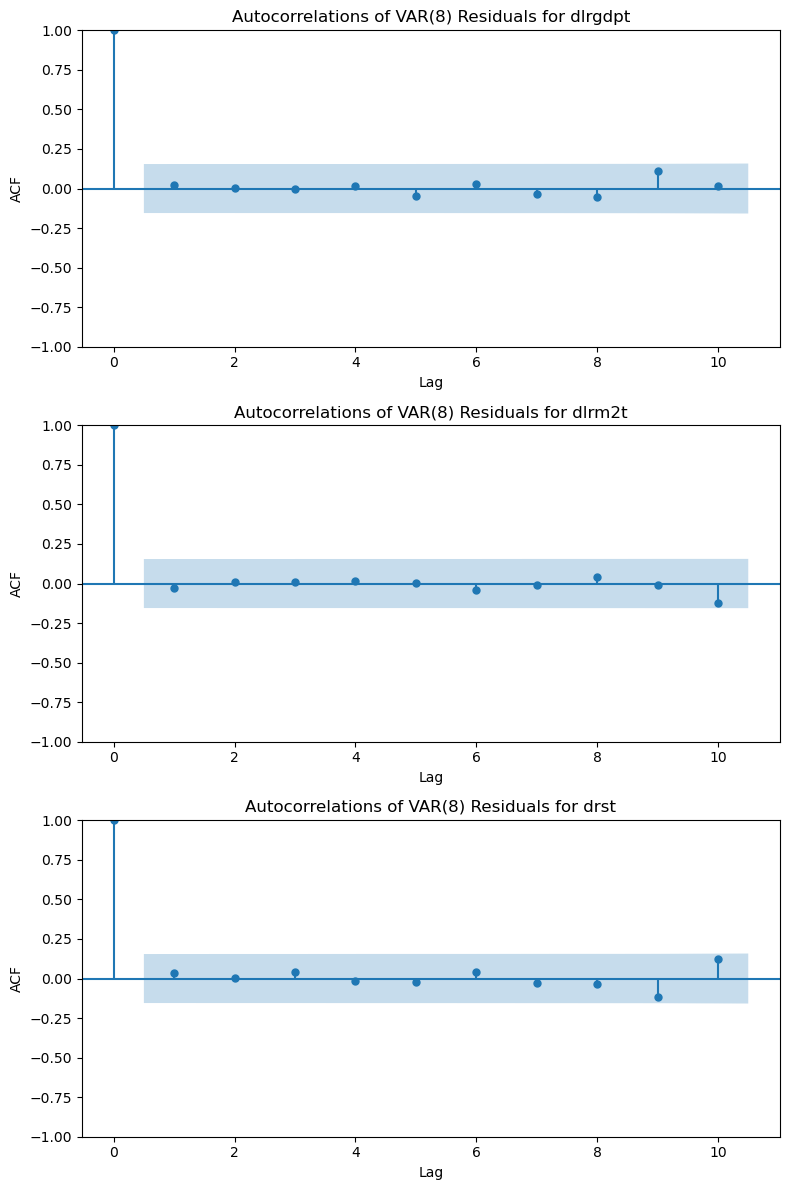

In [51]:
# VAR(8) model
model_8 = VAR(data_clean).fit(8)

residuals_var8 = model_8.resid

acf_resid_var8_dlrgdp = acf(residuals_var8['dlrgdp'], nlags=10, fft=False)
acf_resid_var8_dlrm2 = acf(residuals_var8['dlrm2'], nlags=10, fft=False)
acf_resid_var8_drs = acf(residuals_var8['drs'], nlags=10, fft=False)

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

# dlrgdp
plot_acf(residuals_var8['dlrgdp'], ax=axes[0], lags=10, title='Autocorrelations of VAR(8) Residuals for dlrgdpt')
axes[0].set_ylabel('ACF')
axes[0].set_xlabel('Lag')

# dlrm2
plot_acf(residuals_var8['dlrm2'], ax=axes[1], lags=10, title='Autocorrelations of VAR(8) Residuals for dlrm2t')
axes[1].set_ylabel('ACF')
axes[1].set_xlabel('Lag')

# drs
plot_acf(residuals_var8['drs'], ax=axes[2], lags=10, title='Autocorrelations of VAR(8) Residuals for drst')
axes[2].set_ylabel('ACF')
axes[2].set_xlabel('Lag')

plt.tight_layout()
plt.show()



### VAR(8) fits the data better than VAR(4).  Thus, we continue the analysis with a VAR(8)

### c) As a final check, estimate the VAR(4) and VAR(8) and provide the system statistics (AIC, BIC)

In [52]:
print('VAR(4) aic ={} '.format(model_4.aic))
print('VAR(8) aic ={} '.format(model_8.aic))
print('VAR(4) bic ={} '.format(model_4.bic))
print('VAR(8) bic ={} '.format(model_8.bic))

VAR(4) aic =-20.46236065356371 
VAR(8) aic =-20.560312234415434 
VAR(4) bic =-19.72519729572747 
VAR(8) bic =-19.11882450852458 


BIC is smaller for VAR(4) than VAR(8), while the AIC favor VAR(8).  Putting all evidence (including autocorrelations from Part (b)) together, we choose VAR(8).

### (d) Check the stationarity of the chosen VAR(p).

Roots of the characteristic equation: [14.27771508-0.j          6.60215929-0.j         -3.22391003-0.j
 -0.61223309+1.35302786j -0.61223309-1.35302786j -1.33706809-0.06695705j
 -1.33706809+0.06695705j  0.78903848+1.03392329j  0.78903848-1.03392329j
  1.11582169+0.52846957j  1.11582169-0.52846957j  1.21039025-0.j
  0.58411108-1.04191576j  0.58411108+1.04191576j -0.19822184+1.14678851j
 -0.19822184-1.14678851j  1.10749789+0.31321102j  1.10749789-0.31321102j
 -0.93552144+0.63967152j -0.93552144-0.63967152j  0.15058184+1.11519941j
  0.15058184-1.11519941j -0.60735976+0.91510637j -0.60735976-0.91510637j]


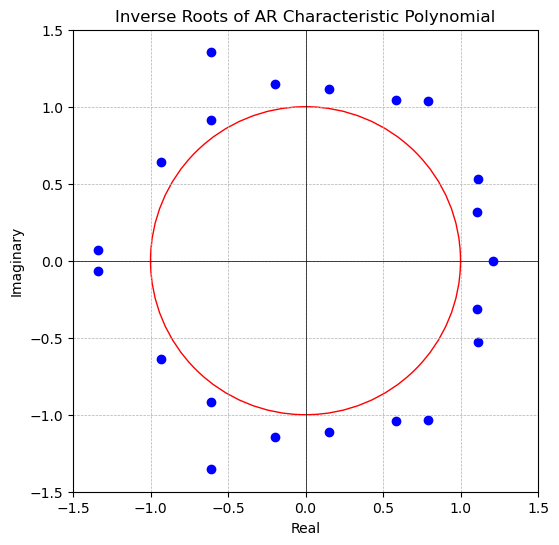

In [55]:
from statsmodels.tsa.api import VAR
import numpy as np


roots = model_8.roots
print(f"Roots of the characteristic equation: {roots}")

plt.figure(figsize=(6,6))
plt.scatter(np.real(roots), np.imag(roots), color='blue')
circle = plt.Circle((0, 0), 1, color='red', fill=False)
plt.gca().add_patch(circle)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.title("Inverse Roots of AR Characteristic Polynomial")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.show()


### We see that all roots greater than one in absolute value. VAR(8) stationary!